In [1]:
import numpy as np
import pandas as pd
import json
# import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
# from sklearn.model_selection import RandomizedSearchCV
from create_embedding import creating_embedding_index, creating_embedding_matrix, get_id_word
from word_index import *
# from attention import AttentionLayer
from preprocesing import *

%matplotlib inline

for module in [np, pd, tf, keras]:
    print(module.__name__, module.__version__)

numpy 1.16.2
pandas 0.18.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
%%time
embedding_index = creating_embedding_index('./datasets_eg/word_embedding/numberbatch-en-17.04b.txt')
len(embedding_index)

Wall time: 2min 45s


418082

In [3]:
with open("./datasets_eg/review_summary_word_id.json", "r", encoding="utf8") as f:
    vocab_to_int = json.load(f) 

int_to_vocab = {idx:word for word, idx in vocab_to_int.items()}

In [4]:
embedding_dim = 300
word_embedding_matrix = get_embedding_matrix(vocab_to_int, embedding_index, embedding_dim)
word_embedding_matrix[:5]

59461


array([[ 0.24775651, -0.89154071,  0.0222307 , ...,  0.00278979,
         0.83843677, -0.56850875],
       [ 0.69144169,  0.32559849, -0.23011514, ..., -0.1637825 ,
         0.04448972,  0.10678255],
       [ 0.56321009,  0.95092865, -0.85065063, ...,  0.3161738 ,
         0.53956146,  0.78181798],
       [ 0.10344128,  0.24403162,  0.89796913, ..., -0.62509446,
        -0.04773155, -0.21823669],
       [ 0.0271    ,  0.1203    , -0.0418    , ..., -0.0197    ,
         0.0192    ,  0.0044    ]])

In [5]:
padded_data = np.load("./datasets_eg/summary_text_padded.npz")
summaries_padded = padded_data["summaries_padded"]
texts_padded = padded_data["texts_padded"]

训练阶段输入   
- encoder_input   
- decoder_input   
- decoder_target   
其中decoder_target是decoder_input的shift一位（如图）   
<img src="https://img-blog.csdn.net/20171201092713541">

In [6]:
def get_dec_input(target_data, vocab_to_int):
    # 补充<GO>,并移除最后一个字符
    GO = np.zeros((len(target_data),1), dtype=np.int32) + vocab_to_int["<GO>"]
    dec_input = np.concatenate([GO, target_data[:,:-1]], axis=1)
    return dec_input

In [7]:
dec_input = get_dec_input(summaries_padded, vocab_to_int)

In [8]:
summaries_padded[:5]

array([[52470, 28227, 46956, 33597,     2],
       [ 3089,     2,     0,     0,     0],
       [53043,  6166,     2,     0,     0],
       [37174,  1660,     2,     0,     0],
       [ 9502, 31839,     2,     0,     0]])

In [9]:
summaries_padded.dtype

dtype('int32')

In [10]:
dec_input[:5]

array([[    3, 52470, 28227, 46956, 33597],
       [    3,  3089,     2,     0,     0],
       [    3, 53043,  6166,     2,     0],
       [    3, 37174,  1660,     2,     0],
       [    3,  9502, 31839,     2,     0]])

In [11]:
# 基本参数
batch_size = 128
epochs = 50
rnn_size = 64 # LSTM 的单元个数
num_samples = len(summaries_padded) # 训练样本的大小
keep_prob = 0.5
num_words = len(vocab_to_int)
summaries_maxlen = 5
texts_maxlen = 84
# 数据集路径
# data_path = 'fra-eng/fra.txt'

In [12]:
encoder_inputs = keras.Input(shape=(texts_maxlen,), name="encoder_inputs")
# Define an input sequence and process it.
embedding_layer = keras.layers.Embedding(num_words, embedding_dim, 
#                                          mask_zero=True,
                                   weights=[word_embedding_matrix], name="embedding")
enco_embedding = embedding_layer(encoder_inputs)
en_lstm_1 = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob,
                              return_sequences=True, name="lstm_1")
enco_output_1 = en_lstm_1(enco_embedding)
en_lstm_2 = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob,
                              return_sequences=True, return_state=True, name="lstm_2")
encoder_outputs, state_h, state_c = en_lstm_2(enco_output_1)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [13]:
decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
# Set up the decoder, using `encoder_states` as initial state.
deco_embedding = embedding_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
de_lstm = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob, 
                           return_sequences=True, return_state=True, name="lstm_3")
decoder_outputs, deco_state_h, deco_state_c = de_lstm(deco_embedding, initial_state=encoder_states)
# Attention layer
attn_layer = keras.layers.Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs,encoder_outputs])
# Concat attention input and decoder LSTM output
concat_layer = keras.layers.Concatenate(axis=-1, name='concat_layer')
decoder_concat_input = concat_layer([decoder_outputs, attn_out])
#dense layer
decoder_dense =  keras.layers.TimeDistributed(keras.layers.Dense(num_words, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [14]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="train_model")

Model: "train_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 84, 64)       93440       embedding[0][0]        

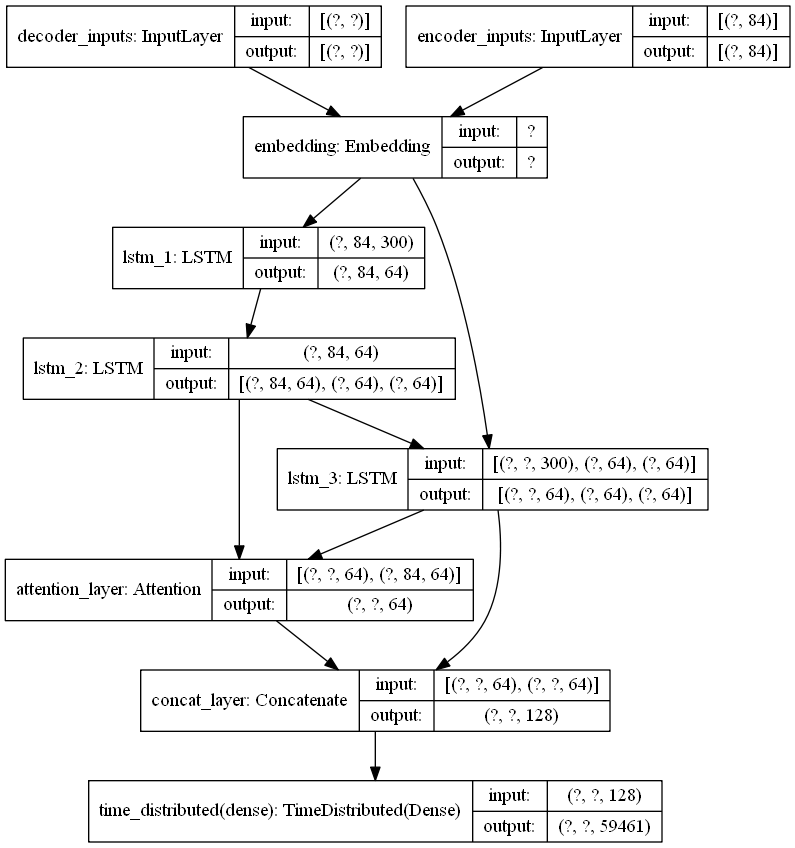

In [15]:
model.summary()
keras.utils.plot_model(model, "./model_img/seq2seq_attn_model.png", show_shapes=True)

In [17]:
# Run training
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [21]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            keras.callbacks.ModelCheckpoint("./checkpoint/seq2seq_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', 
                                            save_weights_only=True,verbose=1,save_best_only=True, period=5)]
history = model.fit([texts_padded, dec_input], summaries_padded, callbacks=callbacks, validation_split=0.1,
          batch_size=batch_size, epochs=epochs)

W1009 17:15:06.105977  6680 callbacks.py:863] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


Train on 511570 samples, validate on 56842 samples
Epoch 1/50
511570/511570 [==============================] - 8020s 16ms/sample - loss: 3.8661 - val_loss: 3.5906
Epoch 2/50
511570/511570 [==============================] - 7778s 15ms/sample - loss: 3.5821 - val_loss: 3.4561
Epoch 3/50
511570/511570 [==============================] - 7836s 15ms/sample - loss: 3.4915 - val_loss: 3.3876
Epoch 4/50
511570/511570 [==============================] - 7837s 15ms/sample - loss: 3.4469 - val_loss: 3.3508
Epoch 5/50
511488/511570 [============================>.] - ETA: 1s - loss: 3.4255
Epoch 00005: val_loss improved from inf to 3.34870, saving model to ./checkpoint/seq2seq_05-3.35.hdf5
511570/511570 [==============================] - 7874s 15ms/sample - loss: 3.4256 - val_loss: 3.3487
Epoch 6/50
511570/511570 [==============================] - 7869s 15ms/sample - loss: 3.4386 - val_loss: 3.3462
Epoch 7/50
511570/511570 [==============================] - 7913s 15ms/sample - loss: 3.4366 - val_loss

In [22]:
model.save_weights('./model_file/seq2seq_attn_weights.ckpt')

In [17]:
model.load_weights('./model_file/copy2/model_file/seq2seq_attn_weights.ckpt')

In [18]:
model.predict([texts_padded[0].reshape((1, -1)), dec_input[0].reshape((1, -1))])

array([[[1.3357429e-08, 7.3121209e-03, 6.1953412e-03, ...,
         2.2649476e-17, 1.2659032e-05, 2.2583733e-17],
        [1.9325405e-10, 3.2487279e-03, 7.9094768e-02, ...,
         4.3204153e-17, 9.6908416e-06, 4.3177624e-17],
        [1.5753483e-10, 2.9704627e-03, 1.7230934e-01, ...,
         1.3292044e-15, 1.0421523e-05, 1.3318437e-15],
        [3.6799673e-18, 3.2260551e-04, 3.2598492e-02, ...,
         4.3680257e-15, 1.0824548e-06, 4.3752136e-15],
        [1.4239918e-12, 6.8757427e-04, 8.6489350e-01, ...,
         7.6565415e-16, 4.5423958e-06, 7.6580318e-16]]], dtype=float32)

In [19]:
# tf.reset_default_graph()
# 建立推断模型
# 定义 sampling 模型
# 定义 encoder 模型，得到输出encoder_states
# encoder_inputs = keras.Input(shape=(texts_maxlen,), dtype=tf.int32, name="encoder_inputs")
# Define an input sequence and process it.
# enco_embedding = embedding_layer(encoder_inputs)
# enco_output_1 = en_lstm_1(enco_embedding)
# encoder_outputs, state_h, state_c = en_lstm_2(enco_output_1)
# We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

encoder_model = keras.Model(encoder_inputs, [encoder_outputs] + encoder_states)

# decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
decoder_state_input_h = keras.Input(shape=(rnn_size,))
decoder_state_input_c = keras.Input(shape=(rnn_size,))

decoder_hidden_state_input = keras.Input(shape=(texts_maxlen, rnn_size))

# 得到解码器的输出以及中间状态
# Get the embeddings of the decoder sequence
dec_emb2 = embedding_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = de_lstm(dec_emb2, 
                                               initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_out_inf= attn_layer([decoder_outputs2,decoder_hidden_state_input])
# concat_layer = model.get_layer("concat_layer")
decoder_inf_concat = concat_layer([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = keras.Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [20]:
o, h, c = encoder_model.predict(texts_padded[0].reshape(1, -1))

In [21]:
target_seq = np.zeros((1,1), dtype=np.int32)
target_seq[0, 0] = vocab_to_int.get("<GO>")
decoder_model.predict([target_seq, o, h, c])

[array([[[1.3357393e-08, 7.3121153e-03, 6.1953310e-03, ...,
          2.2649502e-17, 1.2659009e-05, 2.2583760e-17]]], dtype=float32),
 array([[ 5.60328481e-04,  1.06138280e-02, -6.91536665e-02,
         -6.31795004e-02, -2.07898486e-03,  1.00697614e-02,
         -1.07231643e-03,  1.03260223e-02,  1.11492249e-04,
         -2.29117595e-05, -1.32361578e-03,  3.19119063e-05,
          1.25926584e-01, -3.33988294e-03, -5.24835847e-03,
         -2.34062634e-02,  7.28775084e-01, -3.35617340e-04,
         -7.57747233e-01, -5.29273599e-02,  4.81637602e-04,
         -2.49609109e-02, -9.97846961e-01, -1.47586048e-01,
          1.12125213e-04,  1.26719074e-02,  6.11219406e-02,
          2.96672910e-01,  1.56953186e-02, -1.67092565e-03,
         -7.66191542e-01, -3.40454541e-02,  5.99540919e-02,
          1.33606285e-01, -3.89266573e-03, -2.74199483e-05,
          5.53370453e-03, -1.70474901e-04, -1.08717382e-03,
          1.90220075e-03, -2.03114026e-03, -6.03570305e-02,
         -1.61504344e-04, 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 84)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  17838300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 84, 64)            93440     
_________________________________________________________________
lstm_2 (LSTM)                [(None, 84, 64), (None, 6 33024     
Total params: 17,964,764
Trainable params: 17,964,764
Non-trainable params: 0
_________________________________________________________________


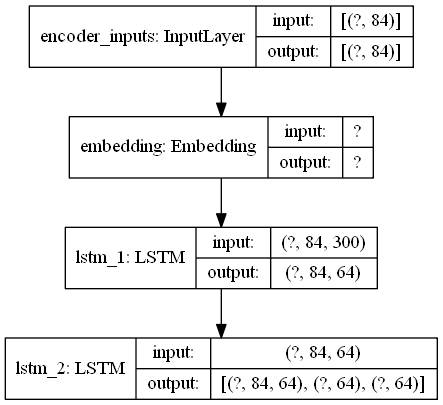

In [22]:
encoder_model.summary()
keras.utils.plot_model(encoder_model, "./model_img/encoder_model.png", show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    decoder_inputs[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64)]         0                                            
____________________________________________________________________________________________

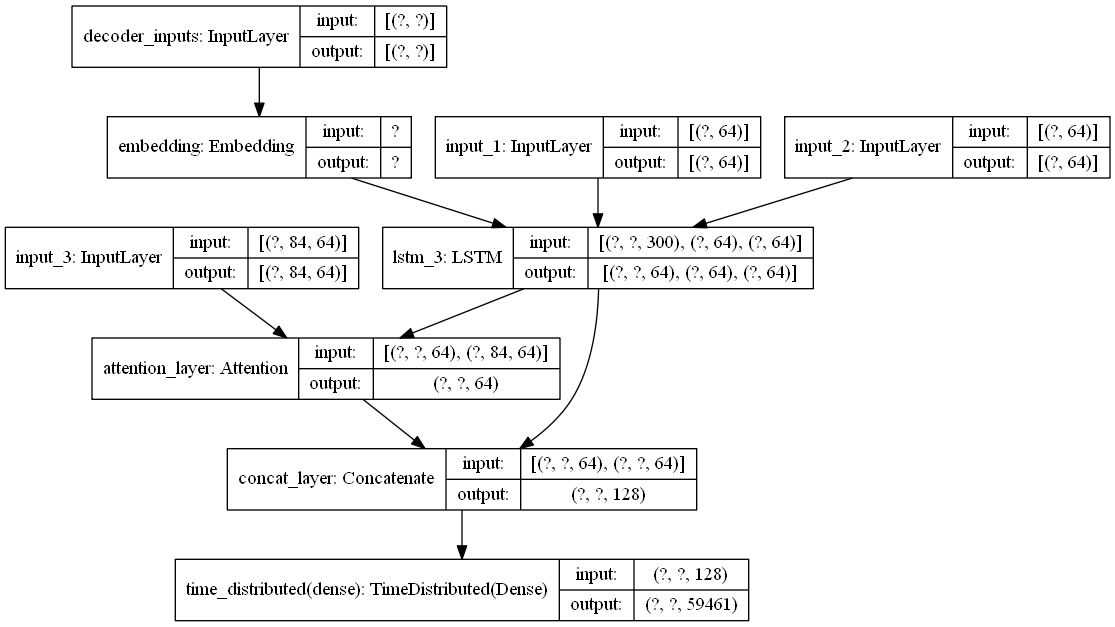

In [24]:
decoder_model.summary()
keras.utils.plot_model(decoder_model, "./model_img/decoder_model.png", show_shapes=True)

In [25]:
def decode_sequence(input_seq):
    # 将输入序列进行编码
    print(input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print(e_out)
    print(e_out.shape)
    print(e_h.shape)
    print(e_c.shape)

    # 生成一个size=1的空序列
    # 将这个空序列的内容设置为开始字符
    target_seq = np.zeros((1,1), dtype=np.int32)
    target_seq[0, 0] = vocab_to_int.get("<GO>")
    print(target_seq)
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = int_to_vocab[sampled_token_index]
        
        if(sampled_token!='<EOS>'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<EOS>'  or len(decoded_sentence.split()) >= (summaries_maxlen-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [26]:
for seq_index in [10, 110, 1110, 11110]:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = texts_padded[seq_index].reshape(1, texts_maxlen)
#     print(input_seq)
    decoded_sentence = decode_sequence(input_seq)
    input_text = [int_to_vocab[i] for i in input_seq[0] if i != vocab_to_int["<PAD>"]]
    
    print("\n*******************我是分隔符,当前index{}********************".format(seq_index))
    print('Input int sentence:', [i for i in texts_padded[seq_index] if i != vocab_to_int["<PAD>"]])
    print('Input text sentence:', " ".join(input_text))
    print('Decoded sentence:', decoded_sentence)

(1, 84)
[[[-0.02318098  0.08897051 -0.0952335  ... -0.0453485   0.00763771
   -0.02708361]
  [-0.03197427  0.34465292 -0.2092869  ...  0.04297781  0.21358055
   -0.25003758]
  [-0.11849683  0.4494577  -0.18718605 ...  0.02988134  0.13797678
   -0.39631113]
  ...
  [-0.60825574  0.64421695 -0.4850083  ... -0.5829086   0.12151629
   -0.8568104 ]
  [-0.6093626   0.6435755  -0.48501483 ... -0.5828441   0.12167944
   -0.85681576]
  [-0.6104255   0.64297396 -0.48502004 ... -0.58278465  0.12182234
   -0.8568199 ]]]
(1, 84, 64)
(1, 64)
(1, 64)
[[3]]

*******************我是分隔符,当前index10********************
Input int sentence: [23727, 56037, 42211, 43867, 38526, 154, 53, 9269, 18989, 46976, 4756, 15053, 42969, 43363, 35633, 7424, 7926, 24363, 18945, 28739, 12477, 25510, 10944, 26912, 19398, 20097, 9680, 22302, 8247, 32108, 23494, 2195, 4183, 23070, 18067, 18989, 27819, 32108, 23494, 26311, 2287, 9269, 18989, 50539, 37847, 2287, 9269, 18989, 33090, 18989, 34178, 7408, 56308, 22971, 43363, 42211, 2

In [31]:
test_text = "the apple tastes great i will buy more tomorrow"
test_seq = test_text.split(" ")
test_int = []
for i in range(texts_maxlen):
    if i <= len(test_seq) - 1:
        test_int.append(vocab_to_int.get(test_seq[i], vocab_to_int["<UNK>"]))
    else:
        test_int.append(vocab_to_int.get("<PAD>"))
print(test_int)
input_seq = np.array(test_int).reshape(1, texts_maxlen)
#     print(input_seq)
decoded_sentence = decode_sequence(input_seq)
input_text = [int_to_vocab[i] for i in input_seq[0] if i != vocab_to_int["<PAD>"]]

print("\n*******************我是分隔符,当前index{}********************".format(seq_index))
print('Input int sentence:', [i for i in test_int if i != vocab_to_int["<PAD>"]])
print('Input text sentence:', " ".join(input_text))
print('Decoded sentence:', decoded_sentence)

[1, 7693, 36310, 9502, 1, 1, 23415, 1, 16872, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(1, 84)
[[[-2.43497826e-02  1.24739140e-01 -1.08380005e-01 ... -4.10725996e-02
   -2.02141629e-04 -2.25036107e-02]
  [ 1.37994349e-01  2.98806518e-01 -8.17369670e-02 ... -3.09351031e-02
   -8.70585034e-04 -8.48731101e-02]
  [ 1.25923023e-01  3.42706740e-01 -6.76806346e-02 ...  1.48117766e-01
    5.64235216e-03 -1.31613806e-01]
  ...
  [-3.57061066e-02  5.34293115e-01 -2.85567552e-01 ...  4.61114317e-01
    8.68152082e-02 -3.78345311e-01]
  [-3.69556956e-02  5.33914566e-01 -2.85576075e-01 ...  4.61021692e-01
    8.68106559e-02 -3.78365755e-01]
  [-3.82049270e-02  5.33535600e-01 -2.85584718e-01 ...  4.60928887e-01
    8.68061185e-02 -3.78386170e-01]]]
(1, 84, 64)
(1, 64)
(1, 64)
[[3]]

*******************我是分隔符,当前index1111

In [32]:
vocab_to_int.get("i")

In [33]:
vocab_to_int.get("I")